# **Producto Integrador de Aprendizaje**




# UANL FIME
# Inteligencia Artificial y Redes Neuronales
CONTENEDOR DE RESIDUOS TOXICOS


Importamos las librerias del proyecto

In [ ]:
# importar librerías
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Para este proyecto usaremos google drive para guardar nuestras muestras de datos y carpetas con imagenes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ya habiendo importado las imagenes de google drive recortamos y dimensionamos las imagenes para que sean 100x100 para un procesamiento más rapido

In [ ]:
from PIL import Image
import os

def recortaryredimensionar(ruta, nueva_res=(128, 128)):
    img = Image.open(ruta).convert("L")  # Convertir a escala de grises
    ancho, alto = img.size

    # Recorte cuadrado centrado
    lado = min(ancho, alto)
    izquierda = (ancho - lado) // 2
    superior = (alto - lado) // 2
    img_cortada = img.crop((izquierda, superior, izquierda + lado, superior + lado))

    # Redimensionar a 64x64
    img_final = img_cortada.resize(nueva_res)
    return img_final

def procesar_carpeta(origen, destino, nueva_res=(128, 128)):
    for root, dirs, files in os.walk(origen):
        for archivo in files:
            if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                ruta = os.path.join(root, archivo)

                # Subcarpeta relativa (clase)
                subcarpeta = os.path.relpath(root, origen)
                carpeta_destino = os.path.join(destino, subcarpeta)
                os.makedirs(carpeta_destino, exist_ok=True)

                # Procesar imagen
                try:
                    imgprocesada = recortaryredimensionar(ruta, nueva_res)
                    nombre_archivo = os.path.splitext(archivo)[0] + ".jpg"
                    ruta_guardado = os.path.join(carpeta_destino, nombre_archivo)
                    imgprocesada.save(ruta_guardado)
                    print(f"Procesado: {ruta} → {ruta_guardado}")
                except Exception as e:
                    print(f"Error con {ruta}: {e}")

# 📂 Define tus carpetas aquí
origen = "/content/drive/MyDrive/PIA/basura/Garbage classification/Garbage classification/trash"      # carpeta con subcarpetas por clase
destino = "/content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica"    # nueva carpeta para las imágenes 128x128 gris

procesar_carpeta(origen, destino)


Procesado: /content/drive/MyDrive/PIA/basura/Garbage classification/Garbage classification/trash/trash137.jpg → /content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica/./trash137.jpg
Procesado: /content/drive/MyDrive/PIA/basura/Garbage classification/Garbage classification/trash/trash135.jpg → /content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica/./trash135.jpg
Procesado: /content/drive/MyDrive/PIA/basura/Garbage classification/Garbage classification/trash/trash13.jpg → /content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica/./trash13.jpg
Procesado: /content/drive/MyDrive/PIA/basura/Garbage classification/Garbage classification/trash/trash129.jpg → /content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica/./trash129.jpg
Procesado: /content/drive/MyDrive/PIA/basura/Garbage classification/Garbage classification/trash/trash128.jpg → /content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica/./trash128.jpg
Procesado: /content/drive/MyDrive/PIA/basura/Garbage classific

para aumentar nuestras imagenes de entrenamiento usamos videos cortos que muestren los objetos toxicos y obtener así diferentes angulos

In [ ]:
#Guardar imagenes de frames de un video
import cv2
import os

# Ruta al video
RUTA_VIDEO = '/content/drive/MyDrive/PIA/vecteezy_a-syringe-with-a-needle-and-pills-on-a-white-surface_50022234.mp4'

# Carpeta de salida
CARPETA_SALIDA = '/content/drive/MyDrive/PIA/guantes2'
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# Guardar una imagen cada N frames
FRAMES_ENTRE_CAPTURAS = 2  # <<-- aquí defines cada cuántos frames guardar (2 en tu caso)

# Cargar el video
video = cv2.VideoCapture(RUTA_VIDEO)

if not video.isOpened():
    print("❌ No se pudo abrir el video.")
    exit()

print(f"📸 Guardando 1 imagen cada {FRAMES_ENTRE_CAPTURAS} frames...")

contador = 0
guardados = 0

while True:
    ret, frame = video.read()
    if not ret:
        break

    if contador % FRAMES_ENTRE_CAPTURAS == 0:
        nombre = f"frame_{guardados:04d}.jpg"
        ruta_guardado = os.path.join(CARPETA_SALIDA, nombre)
        cv2.imwrite(ruta_guardado, frame)
        guardados += 1

    contador += 1

video.release()
print(f"✅ {guardados} frames guardados en: {CARPETA_SALIDA}")


📸 Guardando 1 imagen cada 2 frames...
✅ 106 frames guardados en: /content/drive/MyDrive/PIA/guantes2


Hacemos este proceso con cada carpeta, creando carpetas destino para que el modelo las pueda leer facilmente

Verificamos que las carpetas tengan un número cercano entre ellas para que no haya problemas al entrenar el modelo y sea sesgado por una clase u otra


In [ ]:
import os
carpeta = "/content/drive/MyDrive/PIA/base de datos/sustancia_toxica"
extensiones_validas = ('.jpg', '.jpeg', '.png', '.webp')
# Contar archivos que sean imágenes
imagenes = [f for f in os.listdir(carpeta) if f.lower().endswith(extensiones_validas)]
print(f"Total de imágenes en la carpeta: {len(imagenes)}")

Total de imágenes en la carpeta: 1743


Eliminamos las imagenes de sobra para que las 2 clases esten balanceadas

In [ ]:
#eliminar imagenes
import os

# Ruta a la carpeta en tu Google Drive
carpeta = "/content/drive/MyDrive/PIA/base de datos/sustancia_no_toxica"  # ← cámbiala por tu ruta

# Listar todos los archivos de imagen
extensiones_validas = ('.jpg', '.jpeg', '.png', '.webp')
archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(extensiones_validas)]

# Eliminar hasta 725 imágenes
eliminadas = 0
max_eliminar = 400

for nombre in archivos:
    if eliminadas >= max_eliminar:
        break
    ruta_img = os.path.join(carpeta, nombre)
    try:
        os.remove(ruta_img)
        eliminadas += 1
    except Exception as e:
        print(f"No se pudo eliminar {nombre}: {e}")

print(f"Se eliminaron {eliminadas} imágenes.")

Se eliminaron 400 imágenes.


Ya teniendo esto asegurado nos dedicamos a entrenar el modelo con nuestras imagenes ya procesadas

Clases codificadas: ['sustancia_no_toxica' 'sustancia_toxica']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,129 (7.05 MB)

 Trainable params: 1,848,129 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 438ms/step - accuracy: 0.6156 - loss: 0.6968 - val_accuracy: 0.7983 - val_loss: 0.4752
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 359ms/step - accuracy: 0.7743 - loss: 0.4810 - val_accuracy: 0.8761 - val_loss: 0.3494
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 357ms/step - accuracy: 0.8700 - loss: 0.3404 - val_accuracy: 0.8886 - val_loss: 0.2962
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.8877 - loss: 0.2939 - val_accuracy: 0.8915 - val_loss: 0.2775
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.8990 - loss: 0.2765 - val_accuracy: 0.9039 - val_loss: 0.2471
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - accuracy: 0.9227 - loss: 0.2180 - val_accuracy: 0.9097 - val_loss: 0.2483
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.9212 - loss: 0.2056 - val_accuracy: 0.9068 - val_loss: 0.2536
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 346ms/step - accuracy: 0.9460 - loss: 0.1537 - val_accu

Saved artifact at '/tmp/tmp1_nv8h82'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor_85')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139618168033296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168036560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168031184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168033104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168036752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168037136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168035792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139618168029264: TensorSpec(shape=(), dtype=tf.resource, name=None)


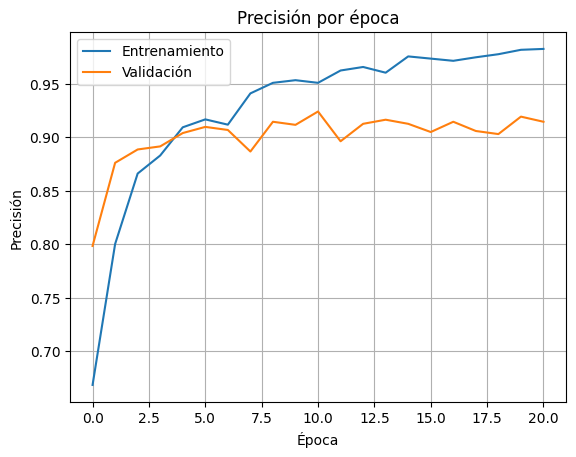

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

# Ruta base del dataset
ruta_dataset = "/content/drive/MyDrive/PIA/base de datos"

# Leer imágenes y etiquetas
X_data = []
y_labels = []
tamano_img = (128, 128)

for clase in os.listdir(ruta_dataset):
    ruta_clase = os.path.join(ruta_dataset, clase)
    if not os.path.isdir(ruta_clase):
        continue
    for archivo in os.listdir(ruta_clase):
        if archivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
            ruta_img = os.path.join(ruta_clase, archivo)
            img = load_img(ruta_img, color_mode='grayscale', target_size=tamano_img)
            img = img_to_array(img) / 255.0
            X_data.append(img)
            y_labels.append(clase)

# Convertir a arrays
X = np.array(X_data)
le = LabelEncoder()
y = le.fit_transform(y_labels)
print(f"Clases codificadas: {le.classes_}")

# División de datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo CNN con BatchNormalization y Dropout
modelo = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

modelo.summary()

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento
history = modelo.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stop]
)

# Guardar etiquetas
with open("/content/etiquetas.txt", "w") as f:
    for label in le.classes_:
        f.write(f"{label}\n")

# Guardar modelo
modelo.save("/content/modelo_toxico.keras")
modelo.save("/content/modelo_toxico.h5")

# Convertir a TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(modelo)
tflite_model = converter.convert()

with open("/content/modelo_toxico.tflite", "wb") as f:
    f.write(tflite_model)

# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.title("Precisión por época")
plt.show()


Con el modelo entrenado y guardado lo usamos para hacer predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

📄 Imagen: 137502659_10371029.png
Probabilidad de 'sustancia_toxica': 1.00
Predicción final: sustancia_toxica


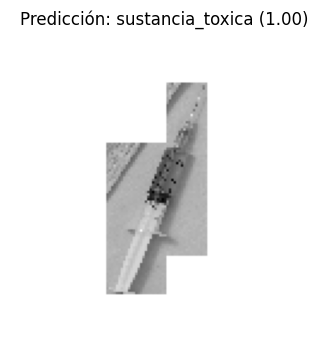

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

📄 Imagen: 19286276_syringe4_Converted_.jpg
Probabilidad de 'sustancia_toxica': 1.00
Predicción final: sustancia_toxica


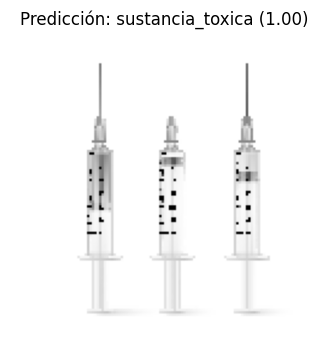

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

📄 Imagen: mano-con-un-guante-de-latex-blanco-para-prevenir-la-contaminacion-por-coronavirus.jpg
Probabilidad de 'sustancia_toxica': 1.00
Predicción final: sustancia_toxica


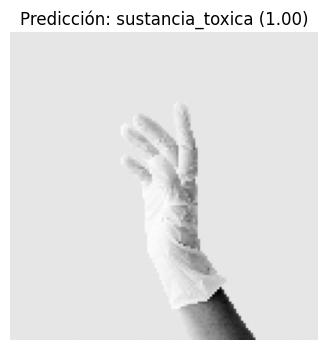

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

📄 Imagen: persona-con-guantes-protectores.jpg
Probabilidad de 'sustancia_toxica': 0.86
Predicción final: sustancia_toxica


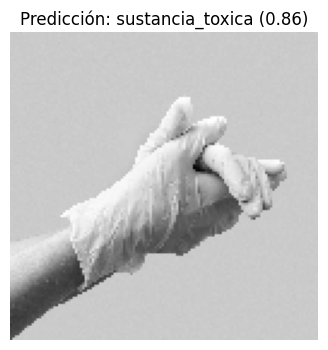

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

📄 Imagen: primer-plano-de-las-manos-de-una-persona-con-guantes-azules.jpg
Probabilidad de 'sustancia_toxica': 0.04
Predicción final: sustancia_no_toxica


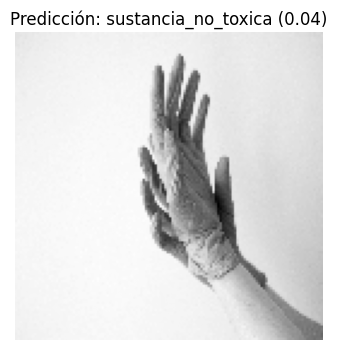

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

📄 Imagen: primer-plano-de-una-jeringa-sobre-un-fondo-marron.jpg
Probabilidad de 'sustancia_toxica': 0.15
Predicción final: sustancia_no_toxica


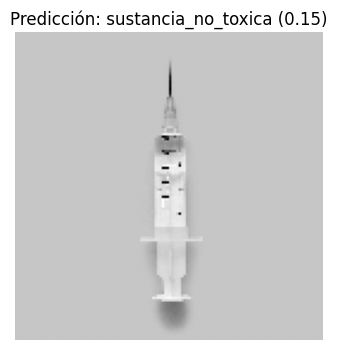

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Cargar modelo Keras (formato .keras) ---
modelo = tf.keras.models.load_model("/content/modelo_toxico.keras")

# --- Cargar etiquetas binarias ---
with open("/content/etiquetas.txt", "r") as f:
    etiquetas = [line.strip() for line in f.readlines()]
assert len(etiquetas) == 2, "Este modelo usa activación sigmoide, necesitas exactamente 2 etiquetas."

# --- Parámetros ---
carpeta_imagenes = "/content/drive/MyDrive/PIA/imagenes_prueba"
tamano_img = (128, 128)  # o el tamaño que usaste al entrenar

# --- Procesar imágenes ---
for archivo in sorted(os.listdir(carpeta_imagenes)):
    if archivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
        ruta_img = os.path.join(carpeta_imagenes, archivo)

        # Preprocesar imagen
        img = load_img(ruta_img, color_mode='grayscale', target_size=tamano_img)
        img_array = img_to_array(img) / 255.0  # Normalización
        img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión de batch

        # Inferencia
        pred = modelo.predict(img_array)[0][0]  # Valor escalar

        # Interpretar predicción con umbral 0.5
        etiqueta_pred = etiquetas[1] if pred >= 0.5 else etiquetas[0]

        # Mostrar resultados
        print(f"\n📄 Imagen: {archivo}")
        print(f"Probabilidad de '{etiquetas[1]}': {pred:.2f}")
        print(f"Predicción final: {etiqueta_pred}")

        plt.figure(figsize=(5, 4))
        plt.imshow(np.squeeze(img_array), cmap='gray')
        plt.axis('off')
        plt.title(f"Predicción: {etiqueta_pred} ({pred:.2f})")
        plt.show()
